<a href="https://colab.research.google.com/github/NongNNew/Project_499/blob/main/Project_499_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CNN

In [11]:
# Upload audio files from github
!git clone https://github.com/NongNNew/Project_499.git

Cloning into 'Project_499'...
remote: Enumerating objects: 1438, done.
remote: Counting objects: 100% (606/606), done.
remote: Compressing objects: 100% (600/600), done.
remote: Total 1438 (delta 64), reused 518 (delta 6), pack-reused 832
Receiving objects: 100% (1438/1438), 232.92 MiB | 24.96 MiB/s, done.
Resolving deltas: 100% (141/141), done.
Checking out files: 100% (1122/1122), done.


In [13]:
# Name of vegetables and fruits 52 types of 56 classes
fruit_veget = ['กระชาย','กระท้อน','กระเทียม1','กระเทียม2','กระเพรา','กล้วยน้ำว้า','กล้วยหอม',
               'ข้าวโพด','ไข่น้ำ',
               'ตะขบไทย','ตะไคร้',
               'ถั่วฝักยาว','ถั่วลันเตา','ถั่วลิสง',
               'ทับทิม',
               'น้อยหน่า','น้ำเต้า',
               'ผักกระเฉด','ผักกุยช่าย','ผักขึ้นช่าย','ผักชะอม','ผักชี','ผักชีฝรั่ง','ผักตำลึง',
               'มะปราง','มะพลับ','มะละกอ','มะกรูด','มะเขือพวง','มะเขือเทศ','มะระ','มะรุม','มะตูม','มันแกว1','มันแกว2','มันเทศ','มันฝรั่ง','มันสำปะหลัง',
               'บวบ','ใบชะพลู1','ใบชะพลู2','ใบบัวบก','ใบแมงลัก','ใบยอ',
               'พริกขี้หนู','พริกสด','พุทรา','เพกา',
               'ฝรั่ง',
               'ฟัก','ฟักทอง',
               'สับปะรด','สะเดา','สะระแหน่',
               'หัวหอม1','หัวหอม2']

# Audio data source
source = {'audio_time':[],
          'sampling_rate':[],
          'feature_extraction':[],
          'label':[],
          'description':[]}

In [14]:
!pip install python_speech_features
import python_speech_features
from scipy.signal.windows import hamming

def feature_mfcc(y,sr):
    return (python_speech_features.mfcc(signal=y, 
                                    samplerate=sr, 
                                    winlen= 512/sr, 
                                    winstep= 160/sr,
                                    numcep= 13,
                                    nfilt= 40, 
                                    nfft= 512,
                                    lowfreq= 0,
                                    highfreq= None,
                                    preemph= 0.97, 
                                    ceplifter= 0,
                                    winfunc= hamming))

In [15]:
import pandas as pd
from glob import glob
import librosa

for types in fruit_veget:
    audio_files = glob('/content/Project_499/Record_audio/' + str(types) + '/*.wav')

    for audio in audio_files:
        y,sr = librosa.load(audio,duration=5,offset=0)
        source['description'].append(str(types))
        source['audio_time'].append(y)
        source['sampling_rate'].append(sr)
        source['feature_extraction'].append(feature_mfcc(y,sr))
        source['label'].append(fruit_veget.index(types))

In [16]:
# tranform dictionary to dataframe 
df = pd.DataFrame.from_dict(source)
df

,audio_time,sampling_rate,feature_extraction,label,description
0,"[-0.0009765625, -0.001449585, -0.001373291, -0...",22050,"[[-13.841251857084886, -10.542052145166839, 1....",0,กระชาย
1,"[1.5258789e-05, -3.0517578e-05, 4.5776367e-05,...",22050,"[[-13.895163210723114, -10.534242113550562, 0....",0,กระชาย
2,"[1.5258789e-05, -3.0517578e-05, 6.1035156e-05,...",22050,"[[-14.225420647550473, -11.767209141048717, 0....",0,กระชาย
3,"[-1.5258789e-05, 1.5258789e-05, -1.5258789e-05...",22050,"[[-13.834222688815137, -11.278032760622157, -1...",0,กระชาย
4,"[-0.00024414062, -0.0002593994, -0.00022888184...",22050,"[[-13.849791727695862, -11.588470019049367, -0...",0,กระชาย
...,...,...,...,...,...
1115,"[-7.6293945e-05, -3.0517578e-05, 4.5776367e-05...",22050,"[[-14.064456461828245, -10.13023715669734, 2.2...",55,หัวหอม2
1116,"[-0.00018310547, -0.00019836426, -0.0002288818...",22050,"[[-13.811710436355032, -12.034727613545233, 0....",55,หัวหอม2
1117,"[0.0, -1.5258789e-05, 3.0517578e-05, -3.051757...",22050,"[[-14.18512183869517, -10.797166196952473, 3.3...",55,หัวหอม2
1118,"[-1.5258789e-05, -3.0517578e-05, -0.0001525878...",22050,"[[-13.975110034884988, -11.68691907136182, -0....",55,หัวหอม2


In [6]:
# Prepare data 
import numpy as np
import pandas as pd


Test = pd.DataFrame(columns=source.keys())
Validation = pd.DataFrame(columns=source.keys())

# Create test data
for description in np.unique(df['description']):
    imp_test = df[df['description']==description].sample(3,random_state=1)
    Test = pd.concat([Test,imp_test], axis=0)

# Create train and validation data
Train = df.drop(Test.index)
for description in np.unique(Train['description']):
    imp_val = Train[Train['description']==description].sample(3,random_state=1)
    Validation = pd.concat([Validation,imp_val], axis=0)
Train = Train.drop(Validation.index)

X_train = np.array(Train['feature_extraction'].to_list())
X_valid = np.array(Validation['feature_extraction'].to_list())
X_test = np.array(Test['feature_extraction'].to_list())
y_train = np.array(Train['label'].to_list())
y_valid = np.array(Validation['label'].to_list())
y_test = np.array(Test['label'].to_list())

In [7]:
# Proportion of data
y_train.shape, y_test.shape, y_valid.shape

((784,), (168,), (168,))

In [8]:
import tensorflow as tf
from tensorflow import keras 

np.random.seed(1)
tf.random.set_seed(1)

# Create model
# Convolutional Neural Networks
model = keras.Sequential()
model.add(keras.layers.Conv2D(128, 5, input_shape=(X_train.shape[1], X_train.shape[2], 1), activation='relu'))
model.add(keras.layers.Dropout(0.25))
model.add(keras.layers.MaxPool2D())
model.add(keras.layers.Conv2D(64, 5, activation='relu',padding='same'))
model.add(keras.layers.Dropout(0.25))
model.add(keras.layers.MaxPool2D())
model.add(keras.layers.Conv2D(128, 5, activation='relu',padding='same'))
model.add(keras.layers.Dropout(0.25))
model.add(keras.layers.MaxPool2D())
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(128, activation='relu'))
model.add(keras.layers.Dropout(0.25))
model.add(keras.layers.Dense(64, activation='relu'))
model.add(keras.layers.Dropout(0.25))
model.add(keras.layers.Dense(len(np.unique(df['label'])), activation='softmax'))
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 683, 9, 128)       3328      
_________________________________________________________________
dropout (Dropout)            (None, 683, 9, 128)       0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 341, 4, 128)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 341, 4, 64)        204864    
_________________________________________________________________
dropout_1 (Dropout)          (None, 341, 4, 64)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 170, 2, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 170, 2, 128)       2

In [9]:
# Train model
history = model.fit(X_train[:,:,:,None], y_train, epochs=100, validation_data=(X_valid[:,:,:,None],y_valid),batch_size=80)

Epoch 1/100
10/10 [==============================] - 17s 116ms/step - loss: 4.1639 - accuracy: 0.0153 - val_loss: 4.0187 - val_accuracy: 0.0655
Epoch 2/100
10/10 [==============================] - 1s 56ms/step - loss: 3.9977 - accuracy: 0.0306 - val_loss: 3.9593 - val_accuracy: 0.0595
Epoch 3/100
10/10 [==============================] - 1s 57ms/step - loss: 3.8299 - accuracy: 0.0485 - val_loss: 3.7499 - val_accuracy: 0.0952
Epoch 4/100
10/10 [==============================] - 1s 57ms/step - loss: 3.6310 - accuracy: 0.0740 - val_loss: 3.5208 - val_accuracy: 0.1548
Epoch 5/100
10/10 [==============================] - 1s 56ms/step - loss: 3.2858 - accuracy: 0.1339 - val_loss: 3.2061 - val_accuracy: 0.2619
Epoch 6/100
10/10 [==============================] - 1s 57ms/step - loss: 2.9378 - accuracy: 0.2168 - val_loss: 2.8338 - val_accuracy: 0.3512
Epoch 7/100
10/10 [==============================] - 1s 56ms/step - loss: 2.5968 - accuracy: 0.2755 - val_loss: 2.4681 - val_accuracy: 0.5774
Epoc

In [10]:
# Evaluate model
print(f'Train Accuracy: { model.evaluate(X_train[:,:,:,None],y_train)[1]}')
print(f'Test Accuracy: {model.evaluate(X_test[:,:,:,None],y_test)[1]}')

25/25 [==============================] - 0s 10ms/step - loss: 0.0095 - accuracy: 1.0000
Train Accuracy: 1.0
6/6 [==============================] - 0s 7ms/step - loss: 0.1394 - accuracy: 0.9702
Test Accuracy: 0.9702380895614624


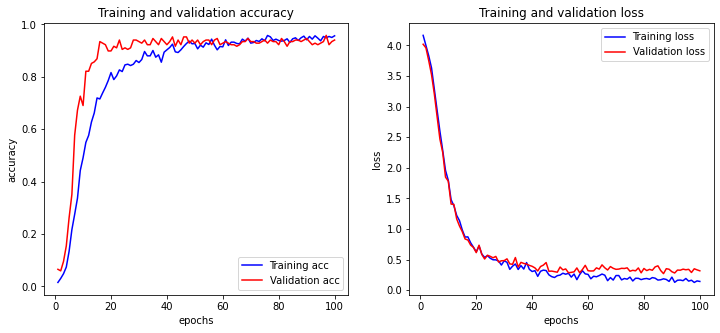

In [11]:
import matplotlib.pyplot as plt

# Learning curve
# plot the accuracy and loss plots between training and validation data
# verify overfitting or underfit 
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
x = range(1,len(acc)+1)

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(x,acc,'b',label='Training acc')
plt.plot(x,val_acc,'r',label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()

plt.subplot(1,2,2)
plt.plot(x,loss,'b',label='Training loss')
plt.plot(x,val_loss,'r',label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()

In [12]:
from sklearn.metrics import classification_report

# classification report
predicted_classes = np.argmax(np.round(model.predict(X_test[:,:,:,None])),axis=1)
correct = np.where(predicted_classes==y_test)[0]
target_names = [f"Class {label}" for label in range(len(np.unique(df['label'])))]

print(f"From {len(y_test)} labels're founding {len(correct)} correct labels.")
print('')
print(classification_report(y_test, predicted_classes, target_names=target_names))

From 168 labels're founding 156 correct labels.

              precision    recall  f1-score   support

     Class 0       0.21      1.00      0.35         3
     Class 1       1.00      0.67      0.80         3
     Class 2       1.00      1.00      1.00         3
     Class 3       1.00      0.67      0.80         3
     Class 4       1.00      1.00      1.00         3
     Class 5       1.00      1.00      1.00         3
     Class 6       1.00      1.00      1.00         3
     Class 7       1.00      0.67      0.80         3
     Class 8       1.00      1.00      1.00         3
     Class 9       1.00      1.00      1.00         3
    Class 10       1.00      0.67      0.80         3
    Class 11       1.00      1.00      1.00         3
    Class 12       1.00      1.00      1.00         3
    Class 13       1.00      0.67      0.80         3
    Class 14       1.00      1.00      1.00         3
    Class 15       1.00      1.00      1.00         3
    Class 16       1.00      1.0

### **Using stratified K Fold to split data**

> ทำเผื่อไว้ก่อน



In [34]:
import tensorflow as tf
import numpy as np
from tensorflow import keras 

np.random.seed(1)
tf.random.set_seed(1)

# Create model
# Convolutional Neural Networks
def create_model():
    model = keras.Sequential()
    model.add(keras.layers.Conv2D(128, 5, input_shape=(X_train.shape[1], X_train.shape[2], 1), activation='relu'))
    model.add(keras.layers.Dropout(0.25))
    model.add(keras.layers.MaxPool2D())
    model.add(keras.layers.Conv2D(64, 5, activation='relu',padding='same'))
    model.add(keras.layers.Dropout(0.25))
    model.add(keras.layers.MaxPool2D())
    model.add(keras.layers.Conv2D(128, 5, activation='relu',padding='same'))
    model.add(keras.layers.Dropout(0.25))
    model.add(keras.layers.MaxPool2D())
    model.add(keras.layers.Flatten())
    model.add(keras.layers.Dense(128, activation='relu'))
    model.add(keras.layers.Dropout(0.25))
    model.add(keras.layers.Dense(64, activation='relu'))
    model.add(keras.layers.Dropout(0.25))
    model.add(keras.layers.Dense(len(np.unique(df['label'])), activation='softmax'))
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    return model

In [35]:
import matplotlib.pyplot as plt

def plot_graphs(loss_hist,loss_val_hist):
    x = range(1,len(loss_hist)+1)

    plt.figure(figsize=(12,5))
    plt.subplot(1,2,1)
    plt.plot(x,loss_hist,"b",label="training loss")
    plt.plot(x,loss_val_hist,"r",label="validation loss")
    plt.title("training and validation loss")
    plt.xlabel("epochs")
    plt.ylabel("loss")
    plt.legend()
    plt.show()

In [36]:
from sklearn.model_selection import StratifiedKFold
import numpy as np

accuracy = []
X = np.array(df['feature_extraction'].to_list())
y = np.array(df['label'].to_list())

skf = StratifiedKFold(n_splits=10, random_state=1,shuffle=True)
skf.get_n_splits(X,y)

10

Training on fold 1/10...


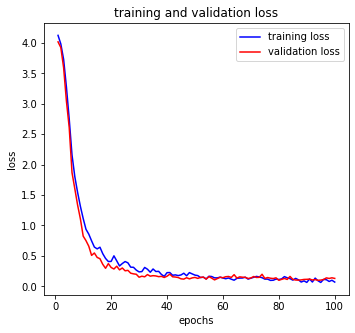

Training on fold 2/10...


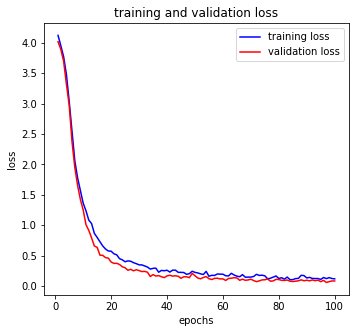

Training on fold 3/10...


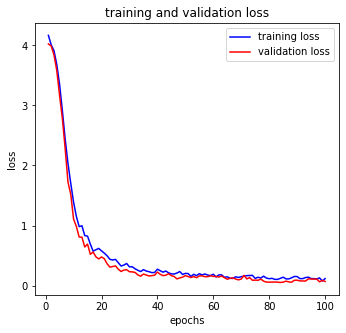

Training on fold 4/10...


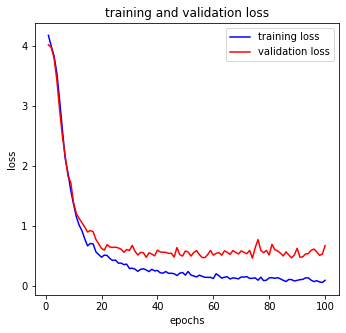

Training on fold 5/10...


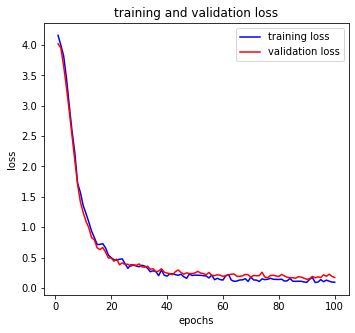

Training on fold 6/10...


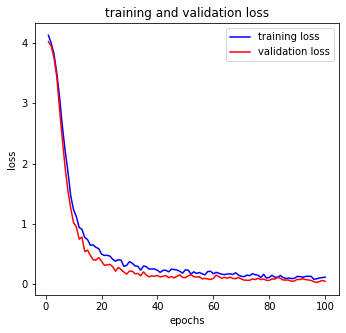

Training on fold 7/10...


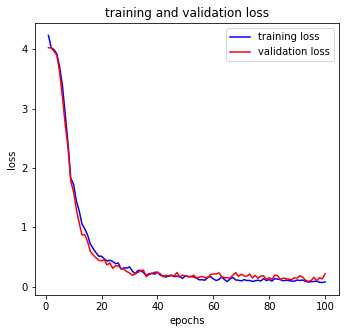

Training on fold 8/10...


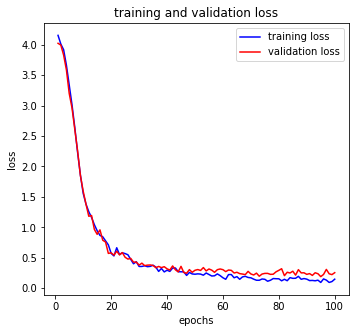

Training on fold 9/10...


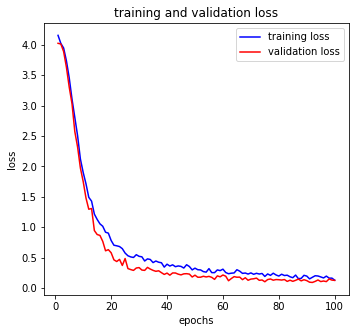

Training on fold 10/10...


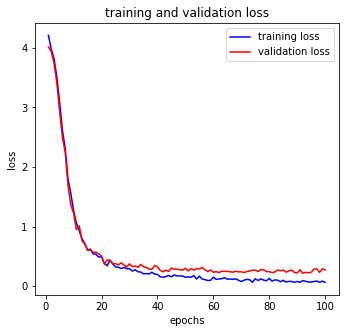

In [37]:
from sklearn.metrics import accuracy_score

for index,(train_index, test_index) in enumerate(skf.split(X,y)):

    print("Training on fold " + str(index+1) + "/10...")

    X_train = X[train_index]
    X_test = X[test_index]
    y_train = y[train_index]
    y_test = y[test_index]

    model = None
    model = create_model()

    history = model.fit(X_train[:,:,:,None],y_train,epochs=100,batch_size=80,validation_data=(X_test[:,:,:,None],y_test),verbose=0)
    loss_hist = history.history['loss']
    loss_val_hist = history.history['val_loss']
    plot_graphs(loss_hist,loss_val_hist)

    predicted_classes = np.argmax(np.round(model.predict(X_test[:,:,:,None])),axis=1)
    correct = np.where(predicted_classes==y_test)[0]

    # print("Last training accuracy: " + str(acc_hist[-1]) + ", last validation accuracy: " + str(val_acc_hist[-1]))
    accuracy.append(len(correct)/len(y_test))

In [38]:
from scipy import stats
stats.describe(accuracy)

DescribeResult(nobs=10, minmax=(0.9017857142857143, 0.9821428571428571), mean=0.9517857142857142, variance=0.0007298752834467115, skewness=-0.6108251571896378, kurtosis=-0.7886228673767604)